In [ ]:
!pip install opencv-python


In [ ]:
!pip install matplotlib


In [ ]:
!pip install pandas


Original image shape: (1572, 2213, 3)
Grayscale image shape: (1572, 2213)


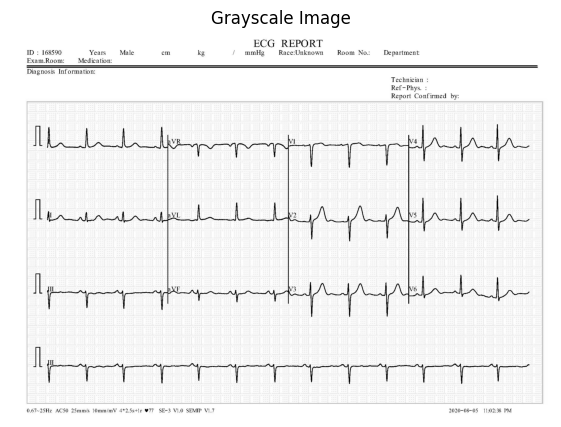

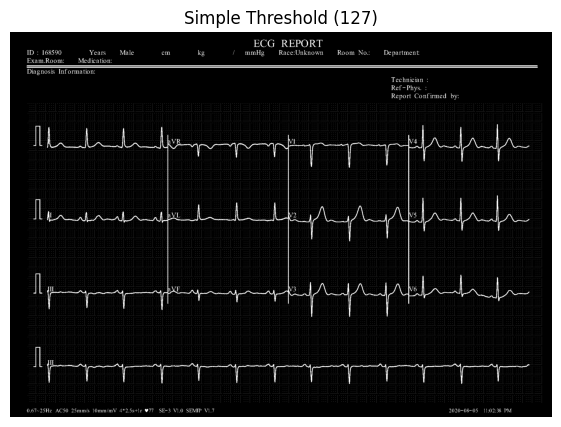

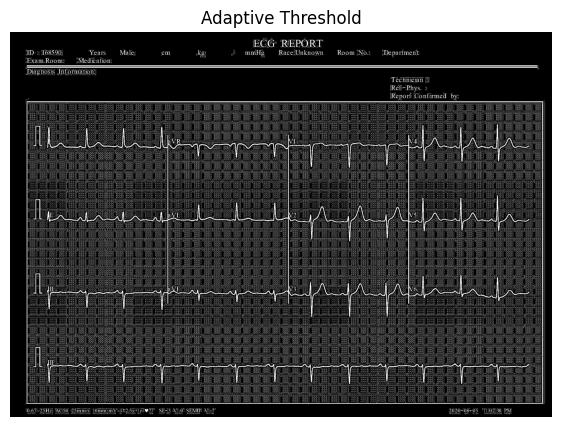

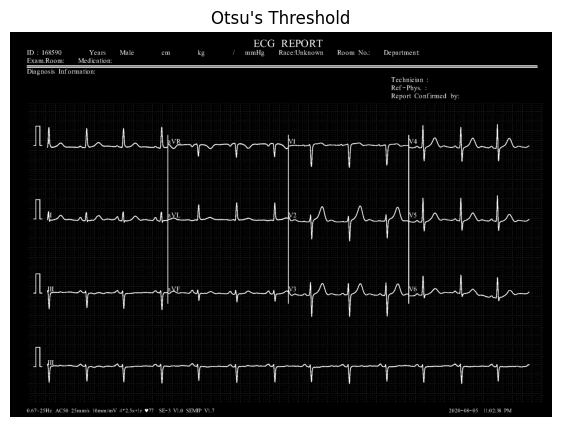

Unique values in thresh1: [  0 255]
Unique values in thresh2: [  0 255]
Unique values in thresh3: [  0 255]

--- Trying Simple Threshold ---


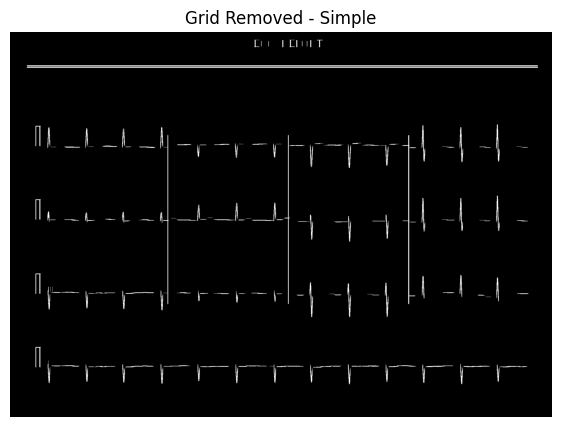

Number of contours found: 161
Number of significant contours (area > 100): 87
Largest contour area: 6256.5


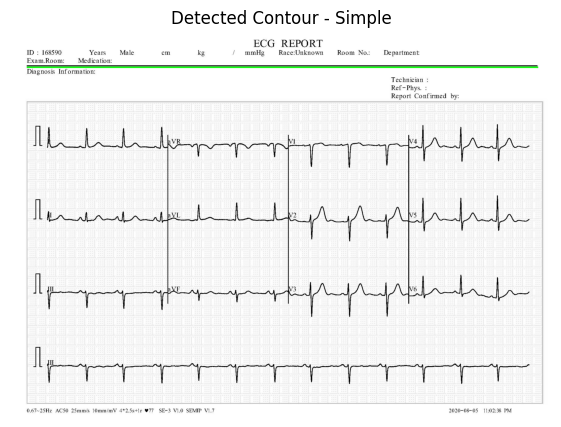

Success with Simple threshold!
Number of data points extracted: 7
Using calibration: 500 px/s, 100 px/mV
Origin: x=69, y=143.57142857142858
Final dataset shape: (4, 2)
   Time (s)  Voltage (mV)
0     0.000      0.015714
2     0.002     -0.014286
3     4.170     -0.014286
4     4.172     -0.004286
Data successfully saved to 'digitized_ecg.csv'


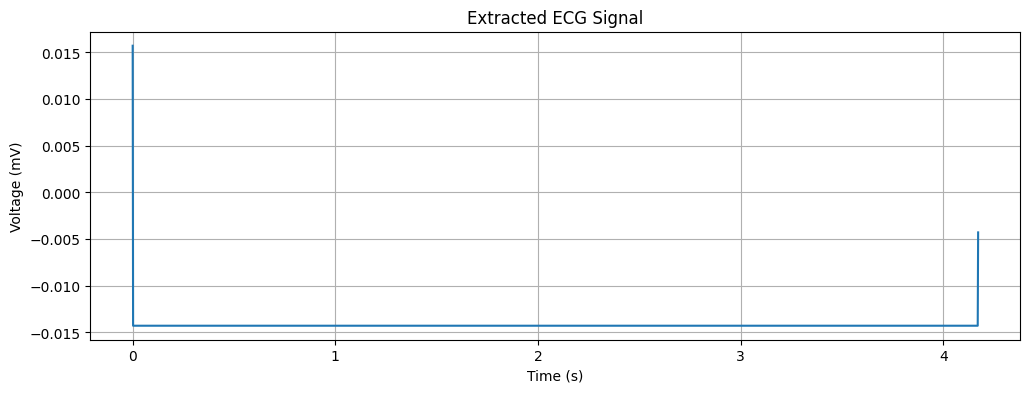

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def debug_show(image, title="Image"):
    """Helper function to display images for debugging"""
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Step 1: Preprocessing
image = cv2.imread('normal_one.jpg')  # Make sure this path is correct!

if image is None:
    raise ValueError("Could not load image! Check the file path.")

print(f"Original image shape: {image.shape}")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(f"Grayscale image shape: {gray.shape}")

# Debug: Show original and grayscale
debug_show(gray, "Grayscale Image")

# Step 2: Try different thresholding approaches
# Method 1: Simple binary threshold
_, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
debug_show(thresh1, "Simple Threshold (127)")

# Method 2: Adaptive threshold - often works better with varying lighting
thresh2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                               cv2.THRESH_BINARY_INV, 11, 2)
debug_show(thresh2, "Adaptive Threshold")

# Method 3: Otsu's threshold - finds optimal threshold value
_, thresh3 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
debug_show(thresh3, "Otsu's Threshold")

print(f"Unique values in thresh1: {np.unique(thresh1)}")
print(f"Unique values in thresh2: {np.unique(thresh2)}")
print(f"Unique values in thresh3: {np.unique(thresh3)}")

# Try each threshold method to find which one works
thresholds = [('Simple', thresh1), ('Adaptive', thresh2), ('Otsu', thresh3)]

for name, thresh in thresholds:
    print(f"\n--- Trying {name} Threshold ---")
    
    # Step 3: Try to remove grid lines
    # Use smaller kernels to avoid removing the ECG signal
    kernel_vertical = np.ones((1, 20), np.uint8)  # Reduced from 50 to 20
    kernel_horizontal = np.ones((20, 1), np.uint8)  # Reduced from 50 to 20
    
    # Remove vertical grid lines
    no_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_vertical)
    # Remove horizontal grid lines  
    no_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_horizontal)
    
    # Combine results
    grid_removed = cv2.bitwise_or(no_vertical, no_horizontal)
    
    debug_show(grid_removed, f"Grid Removed - {name}")
    
    # Find contours
    contours, hierarchy = cv2.findContours(grid_removed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours found: {len(contours)}")
    
    if len(contours) > 0:
        # Filter contours by area to remove noise
        min_contour_area = 100  # Adjust this based on your image size
        significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
        print(f"Number of significant contours (area > {min_contour_area}): {len(significant_contours)}")
        
        if len(significant_contours) > 0:
            largest_contour = max(significant_contours, key=cv2.contourArea)
            print(f"Largest contour area: {cv2.contourArea(largest_contour)}")
            
            # Create visualization
            result = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
            cv2.drawContours(result, [largest_contour], -1, (0, 255, 0), 2)
            debug_show(result, f"Detected Contour - {name}")
            
            # Proceed with this successful threshold
            successful_thresh = thresh
            successful_contour = largest_contour
            print(f"Success with {name} threshold!")
            break
else:
    # If no contours found with any method, try without grid removal
    print("\n--- Trying without grid removal ---")
    for name, thresh in thresholds:
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        print(f"{name} threshold without grid removal - contours: {len(contours)}")
        
        if len(contours) > 0:
            min_contour_area = 100
            significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
            
            if len(significant_contours) > 0:
                largest_contour = max(significant_contours, key=cv2.contourArea)
                print(f"Success with {name} threshold without grid removal!")
                successful_thresh = thresh
                successful_contour = largest_contour
                break
    else:
        raise ValueError("No contours found in the image with any method! The image might be too noisy or have poor contrast.")

# If we successfully found a contour, proceed with data extraction
if 'successful_contour' in locals():
    # Step 4: Extract points from the successful contour
    x_coords = successful_contour[:, 0, 0]
    y_coords = successful_contour[:, 0, 1]
    
    print(f"Number of data points extracted: {len(x_coords)}")
    
    # Step 5: Calibration (You MUST adjust these values for your specific image)
    # You need to determine these by examining your ECG image:
    pixels_per_second = 500   # ⚠️ CHANGE THIS: Measure how many pixels represent 1 second
    pixels_per_millivolt = 100 # ⚠️ CHANGE THIS: Measure how many pixels represent 1 mV
    x_origin = min(x_coords)   # Using min X as origin
    y_origin = np.mean(y_coords)  # Using mean Y as baseline
    
    print(f"Using calibration: {pixels_per_second} px/s, {pixels_per_millivolt} px/mV")
    print(f"Origin: x={x_origin}, y={y_origin}")
    
    # Convert pixels to time and voltage
    time_series = (x_coords - x_origin) / pixels_per_second
    voltage_series = (y_origin - y_coords) / pixels_per_millivolt
    
    # Step 6: Save as digital data
    import pandas as pd
    df = pd.DataFrame({'Time (s)': time_series, 'Voltage (mV)': voltage_series})
    df = df.sort_values(by='Time (s)')  # Ensure data is sorted by time
    df = df.drop_duplicates(subset=['Time (s)'])  # Remove duplicate time points
    
    print(f"Final dataset shape: {df.shape}")
    print(df.head())
    
    df.to_csv('digitized_ecg.csv', index=False)
    print("Data successfully saved to 'digitized_ecg.csv'")
    
    # Plot the extracted data
    plt.figure(figsize=(12, 4))
    plt.plot(df['Time (s)'], df['Voltage (mV)'])
    plt.title('Extracted ECG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.grid(True)
    plt.show()